In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import cv2 as cv
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input
/kaggle/input/UBC-OCEAN
/kaggle/input/UBC-OCEAN/test_thumbnails
/kaggle/input/UBC-OCEAN/train_images
/kaggle/input/UBC-OCEAN/train_thumbnails
/kaggle/input/UBC-OCEAN/test_images


In [2]:
train_image_dir = '../input/UBC-OCEAN/train_images'
test_image_dir = '../input/UBC-OCEAN/test_images'
train_thumbnails_folder_path = '../input/UBC-OCEAN/train_thumbnails'
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'

# Loading training label file

In [3]:
train_data = pd.read_csv("../input/UBC-OCEAN/train.csv")
train_data.head()

image_id label  image_width  image_height  is_tma
0         4  HGSC        23785         20008   False
1        66  LGSC        48871         48195   False
2        91  HGSC         3388          3388    True
3       281  LGSC        42309         15545   False
4       286    EC        37204         30020   False

* Since the 'train_thumbnails' folder contains smaller-sized images, we can use them for model processing. However, not all images in the training set are located in 'train_thumbnails,' so we need to identify the missing ones and process them accordingly.

In [4]:
train_files = [filename.split('.')[0] for filename in os.listdir(train_image_dir)]
thumbnails_files = [filename.replace('_thumbnail', '').split('.')[0] for filename in os.listdir(train_thumbnails_folder_path)]

In [5]:
train_set = set(train_files)
thumbnails_set = set(thumbnails_files)

missing_image_ids = train_set - thumbnails_set
missing_image_ids_list = list(missing_image_ids)

print("Image IDs in train_files but not in thumbnails_files:")
print(missing_image_ids_list)

Image IDs in train_files but not in thumbnails_files:
['35565', '4134', '9200', '37385', '50932', '48734', '47035', '91', '17637', '29084', '57696', '13568', '8280', '36302', '21020', '31594', '42857', '53655', '36783', '36583', '61797', '41368', '41586', '44603', '40864']


In [6]:
# Missing Image id list
missing_image_ids_list = [int(image_id) for image_id in missing_image_ids_list]
filtered_train_data = train_data[train_data['image_id'].isin(missing_image_ids_list)]

filtered_train_data.head()

image_id label  image_width  image_height  is_tma
2          91  HGSC         3388          3388    True
37       4134    MC         2964          2964    True
76       8280  HGSC         2964          2964    True
83       9200    MC         3388          3388    True
112     13568  LGSC         2964          2964    True

* Since all the missing images in thumbnails are TMA images that are small sized, we can use them from the train_images folder instead.

In [7]:
train_data['full_path'] = ''
for index, row in train_data.iterrows():
    image_id = row['image_id']
    if image_id in missing_image_ids_list:
        train_data.at[index, 'full_path'] = os.path.join(train_image_dir, str(image_id) + '.png')
    else:
        train_data.at[index, 'full_path'] = os.path.join(train_thumbnails_folder_path, str(image_id) + '_thumbnail.png')

train_data.head()

image_id label  image_width  image_height  is_tma  \
0         4  HGSC        23785         20008   False   
1        66  LGSC        48871         48195   False   
2        91  HGSC         3388          3388    True   
3       281  LGSC        42309         15545   False   
4       286    EC        37204         30020   False   

                                           full_path  
0  ../input/UBC-OCEAN/train_thumbnails/4_thumbnai...  
1  ../input/UBC-OCEAN/train_thumbnails/66_thumbna...  
2             ../input/UBC-OCEAN/train_images/91.png  
3  ../input/UBC-OCEAN/train_thumbnails/281_thumbn...  
4  ../input/UBC-OCEAN/train_thumbnails/286_thumbn...

# Exploratory Data Analysis(EDA)

#### Label and Image Type Distribution

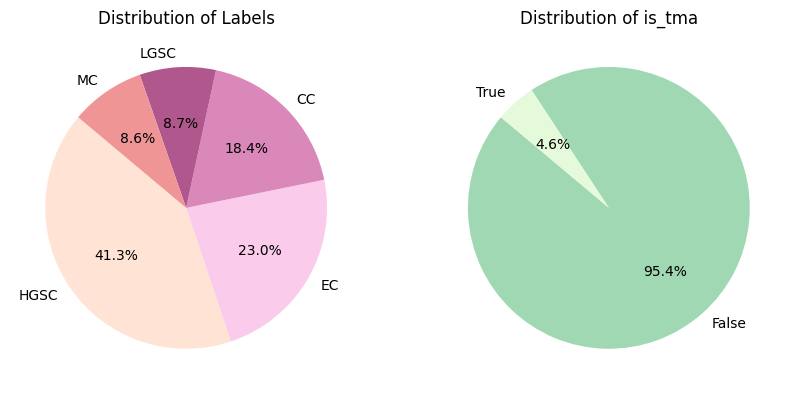

In [8]:
colors = ['#FFE4D6', '#FACBEA', '#D988B9', '#B0578D', '#EF9595']

# Extracting label distribution
labels = train_data['label'].value_counts().index
sizes = train_data['label'].value_counts().values

# Extracting is_tma distribution
is_tma_counts = train_data['is_tma'].value_counts()

# Plotting side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plotting the pie chart for label distribution
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax1.set_title('Distribution of Labels')

# Plotting the pie chart for is_tma distribution
ax2.pie(is_tma_counts, labels=is_tma_counts.index, autopct='%1.1f%%', startangle=140, colors=['#A0D8B3', '#E5F9DB'])
ax2.set_title('Distribution of is_tma')

plt.show()

#### Statistice of images for each label

In [9]:
columns_to_exclude = ['image_id']
styled_summaries = {}

for label in train_data['label'].unique():
    filtered_data = train_data[train_data['label'] == label].drop(columns=columns_to_exclude)
    sta_summary = filtered_data.describe(include=['float64', 'int64', 'float', 'int']).round(2)
    styled_summary = sta_summary.T.style.background_gradient(cmap='magma', low=0.2, high=0.1).set_caption(f'<h2 style="text-align:center;font-size:15px">{label} Summary Table')
    styled_summaries[label] = styled_summary

# Display the styled summaries for each label
for label, styled_summary in styled_summaries.items():
    display(styled_summary)

#### Boxplot of image_width and image_height for each label

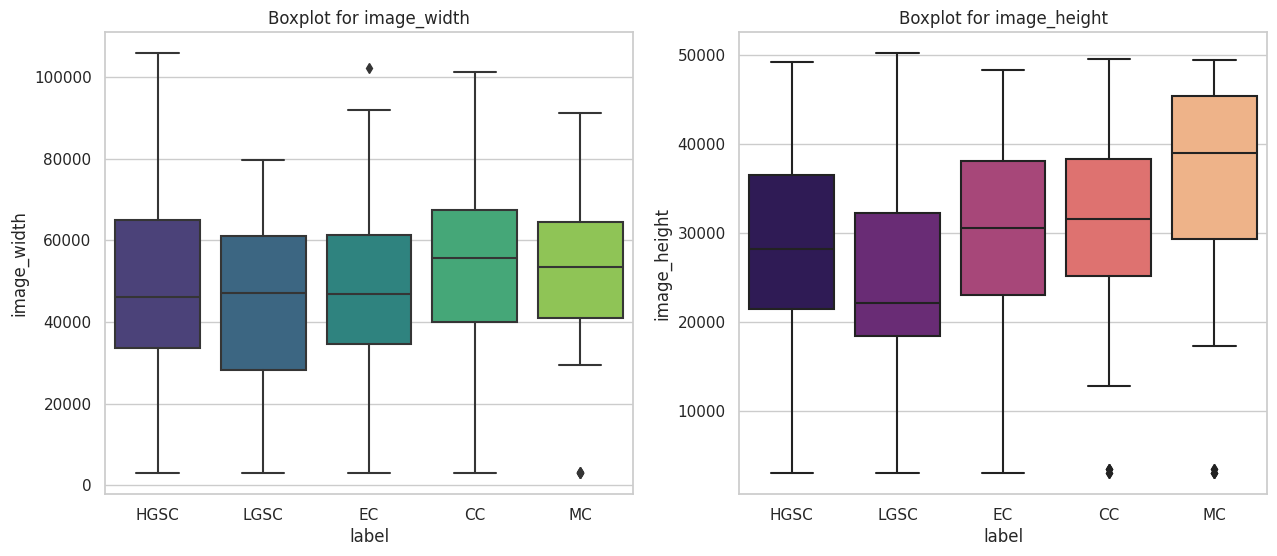

In [10]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots for 'image_width' and 'image_height'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Boxplot for image_width
sns.boxplot(x='label', y='image_width', data=train_data, palette='viridis', ax=axes[0])
axes[0].set_title('Boxplot for image_width')

# Boxplot for image_height
sns.boxplot(x='label', y='image_height', data=train_data, palette='magma', ax=axes[1])
axes[1].set_title('Boxplot for image_height')

plt.show()

#### Thumnails and train image distribution

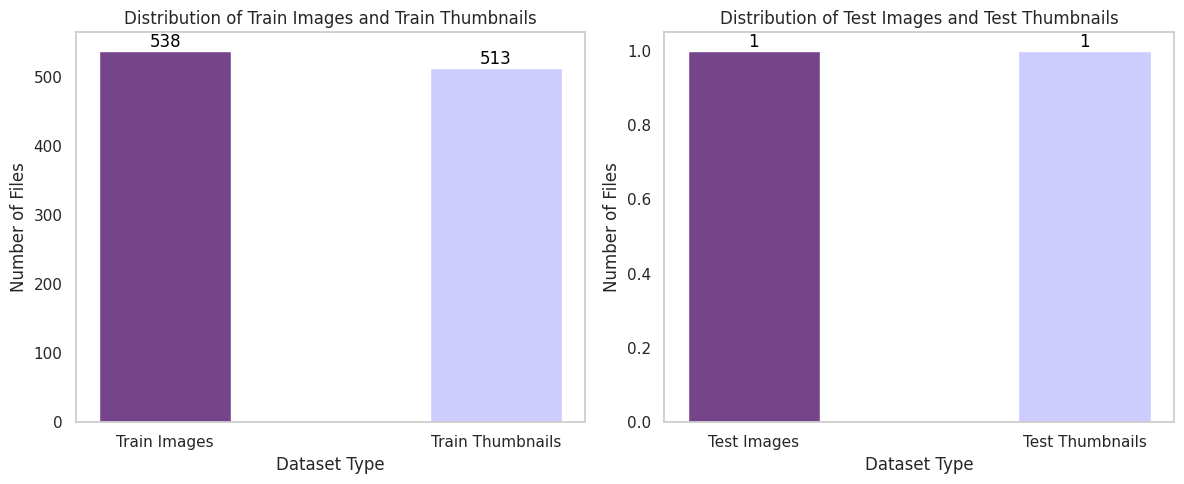

In [11]:
def plot_distribution(image_dir, thumbnail_dir, data_type, ax):
    image_count = len(os.listdir(image_dir))
    thumbnail_count = len(os.listdir(thumbnail_dir))

    labels = ['Images', 'Thumbnails']
    counts = [image_count, thumbnail_count]

    bars = ax.bar([data_type + ' ' + label for label in labels], counts, color=['#76448A', '#CCCCFF'], width=0.4)  # Adjusted bar width

    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        text_ypos = max(yval, 0.5)
        ax.text(bar.get_x() + bar.get_width()/2, text_ypos, round(count, 2), ha='center', va='bottom', color='black')

    ax.grid(False)
    ax.set_title(f'Distribution of {data_type} Images and {data_type} Thumbnails')
    ax.set_xlabel('Dataset Type')
    ax.set_ylabel('Number of Files')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_distribution(train_image_dir, train_thumbnails_folder_path, 'Train', axes[0])
plot_distribution(test_image_dir, test_thumbnails_folder_path, 'Test', axes[1])

plt.tight_layout()
plt.show()

#### Randomly plot images from training set

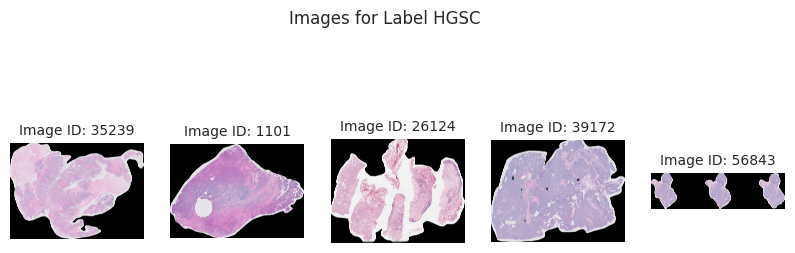

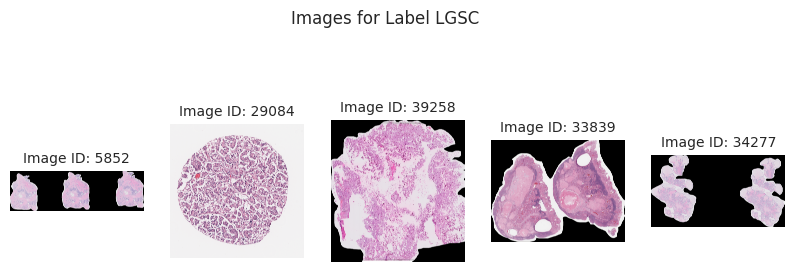

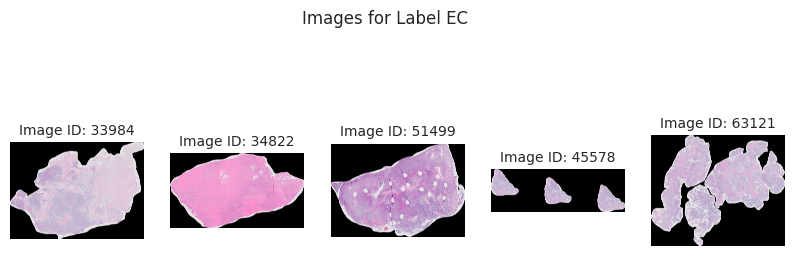

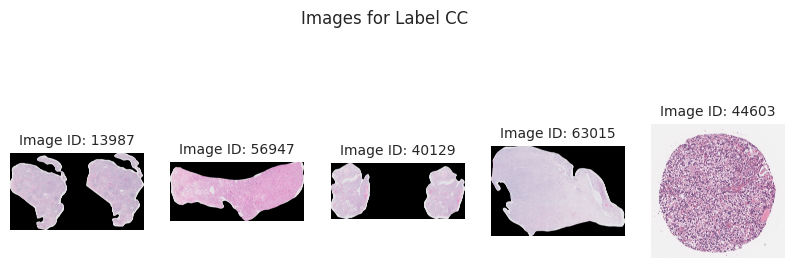

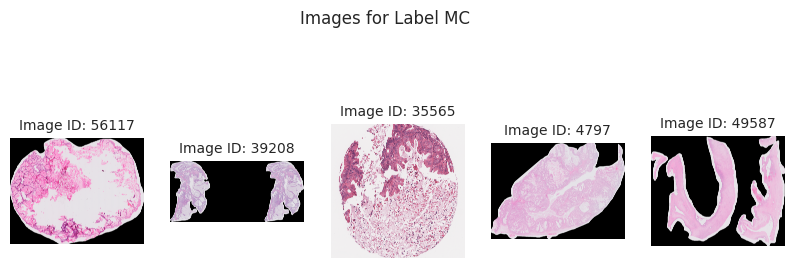

In [12]:
label_column = 'label'
path_column = 'full_path'
image_id_column = 'image_id'

unique_labels = train_data[label_column].unique()

images_per_label = 5

# Randomly select and plot 5 images for each label
for label in unique_labels:
    label_data = train_data[train_data[label_column] == label]
    sample_images = label_data.sample(min(images_per_label, len(label_data)))

    plt.figure(figsize=(10, 3))
    plt.suptitle(f'Images for Label {label}', y=1.1, fontsize=12)  # Adjusted font size

    for i, (_, row) in enumerate(sample_images.iterrows()):
        image_path = row[path_column]
        image = Image.open(image_path)

        plt.subplot(1, images_per_label, i + 1)
        plt.imshow(image)
        plt.title(f'Image ID: {row[image_id_column]}', fontsize=10)
        plt.axis('off')

    plt.show()

#### Plot images from test set

In [13]:
test_data = pd.read_csv('../input/UBC-OCEAN/test.csv')
test_data.head()

image_id  image_width  image_height
0        41        28469         16987

In [14]:
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'
test_data['full_path'] = test_data['image_id'].apply(lambda x: os.path.join(test_thumbnails_folder_path, f"{x}_thumbnail.png"))

test_data

image_id  image_width  image_height  \
0        41        28469         16987   

                                           full_path  
0  ../input/UBC-OCEAN/test_thumbnails/41_thumbnai...

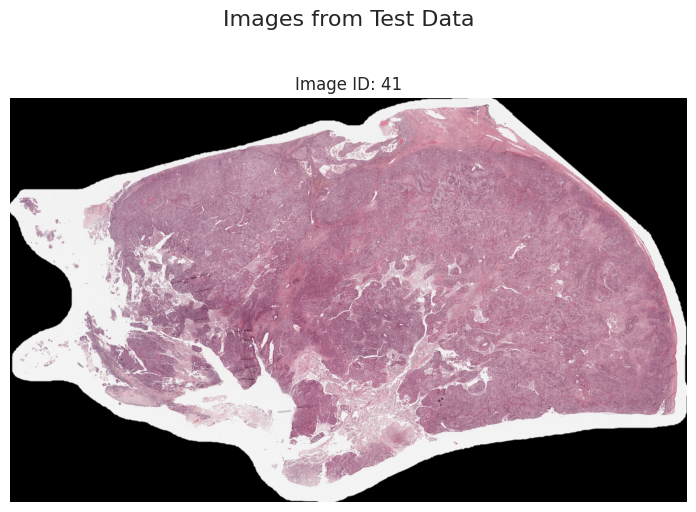

In [15]:
image_id_column = 'image_id'
width_column = 'image_width'
height_column = 'image_height'
path_column = 'full_path'

num_images_to_plot = len(test_data)

plt.figure(figsize=(10, 5 * num_images_to_plot))
plt.suptitle(f'Images from Test Data', y=1.02, fontsize=16)

for i, (_, row) in enumerate(test_data.iterrows()):
    image_path = row[path_column]
    image = Image.open(image_path)

    plt.subplot(num_images_to_plot, 1, i + 1)
    plt.imshow(image)
    plt.title(f'Image ID: {row[image_id_column]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [16]:
# Convert text labels to numerical labels
label_mapping = {'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}
train_data['numerical_label'] = train_data['label'].map(label_mapping)

In [17]:
label_counts = train_data['label'].value_counts()
label_counts

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

* As indicated above, the classes are very imbalanced. Therefore, we increase the number of images for each class by upsampling (The number increase can vary by models)

In [18]:
from sklearn.utils import resample

# Define the target number of samples for each class
target_samples = 222

# Resample each class to have the target number of samples
resampled_data = []
for label in train_data['numerical_label'].unique():
    class_data = train_data[train_data['numerical_label'] == label]
    resampled_class = resample(class_data, replace=True, n_samples=target_samples, random_state=42)
    resampled_data.append(resampled_class)

balanced_train_data = pd.concat(resampled_data)

# Data Transformation

#### Data Normalization and convert image data to numpy array

In [19]:
# Resize images to 512x512
image_size = (512, 512)

x_balanced = np.empty(shape=(len(balanced_train_data), *image_size, 3), dtype=np.uint8)
y_balanced = np.empty(shape=len(balanced_train_data), dtype=np.uint8)

for index, full_path in enumerate(balanced_train_data['full_path']):
    image_array = Image.open(full_path).resize(image_size).convert('RGB')
    x_balanced[index] = np.array(image_array)
    y_balanced[index] = balanced_train_data.iloc[index]['numerical_label']

print(x_balanced.shape)
print(y_balanced.shape)

(1110, 512, 512, 3)
(1110,)


#### Set target to one-hot labels for classification problem

In [20]:
from sklearn.preprocessing import OneHotEncoder

y_targets_balanced = y_balanced.reshape(len(y_balanced), -1)
enc = OneHotEncoder()
enc.fit(y_targets_balanced)
y_balanced = enc.transform(y_targets_balanced).toarray()
print(y_balanced.shape)

(1110, 5)


In [21]:
print(y_balanced[:5])

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


#### Data Augumentation for training data to increase the variation of images

In [22]:
from sklearn.model_selection import train_test_split

# Split the balanced data into 80% training and 20% validation
x_train, x_val, y_train, y_val  = train_test_split(
    x_balanced, y_balanced, test_size=0.2, random_state=1, stratify=y_balanced
)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((888, 512, 512, 3), (222, 512, 512, 3), (888, 5), (222, 5))

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

#### Image after agumentation

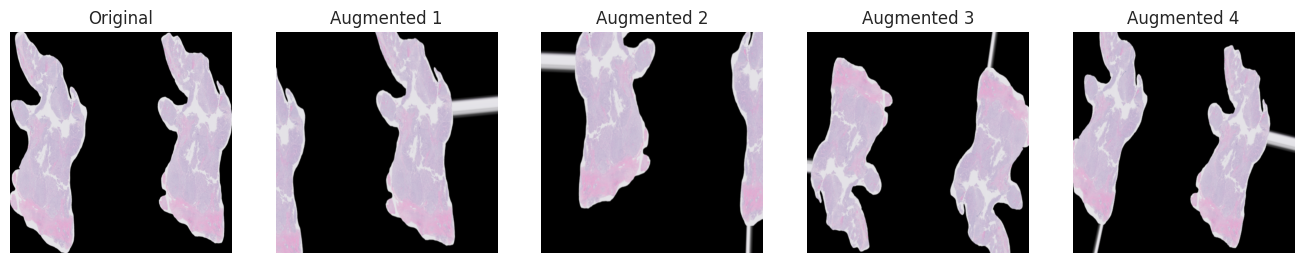

In [24]:
# Choose a sample image from x_train
sample_image = x_train[2]
sample_image = np.expand_dims(sample_image, axis=0)

# Generate augmented images
augmented_images = datagen.flow(sample_image, batch_size=5)


plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0].astype('uint8'))
plt.axis('off')
plt.title('Original')

# Plot the augmented images
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image[0].astype('uint8'))
    plt.axis('off')
    plt.title(f'Augmented {i + 1}')

    if i == 3:
        break  # Display only 4 augmented images

plt.show()

# Feature Engineering

In [25]:
# Examine one sample image from each label
feature_extraction_df = train_data.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)
feature_extraction_df = feature_extraction_df[['image_id', 'label', 'full_path']]

feature_extraction_df.head()

image_id label                                          full_path
0     42296    CC  ../input/UBC-OCEAN/train_thumbnails/42296_thum...
1     53655    EC          ../input/UBC-OCEAN/train_images/53655.png
2     12159  HGSC  ../input/UBC-OCEAN/train_thumbnails/12159_thum...
3     26862  LGSC  ../input/UBC-OCEAN/train_thumbnails/26862_thum...
4     35565    MC          ../input/UBC-OCEAN/train_images/35565.png

#### Color Histograms

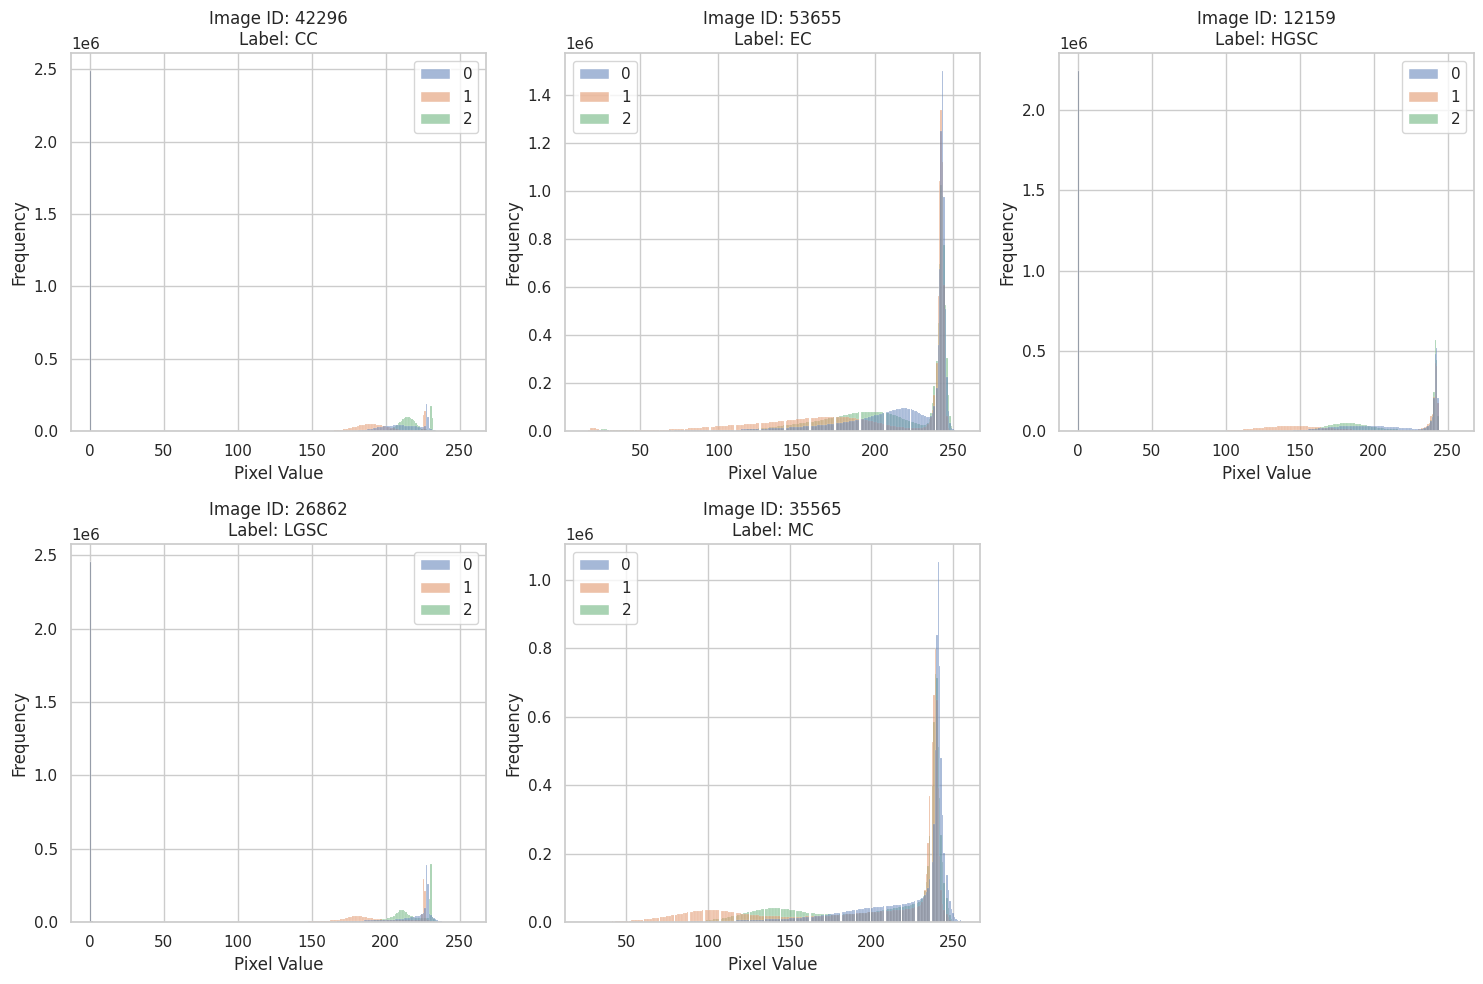

In [26]:
import math

def create_color_histogram(image_path, image_id, label):
    image = Image.open(image_path)
    np_image = np.array(image)
    flattened_array = np_image.reshape((-1, 3))

    # Plot the color histogram using seaborn
    sns.histplot(flattened_array, bins=256, kde=False)
    plt.title(f'Image ID: {image_id}\nLabel: {label}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')


num_images = len(feature_extraction_df)
num_rows = math.ceil(num_images / 3)


plt.figure(figsize=(15, 5 * num_rows))


for idx, row in feature_extraction_df.iterrows():
    subplot_position = (num_rows, 3, idx % (3 * num_rows) + 1)

    plt.subplot(*subplot_position)
    create_color_histogram(row['full_path'], row['image_id'], row['label'])

plt.tight_layout()
plt.show()

#### Grayscale Features

Flattened Array for Image ID 0 and Label CC:
[0 0 0 ... 0 0 0]



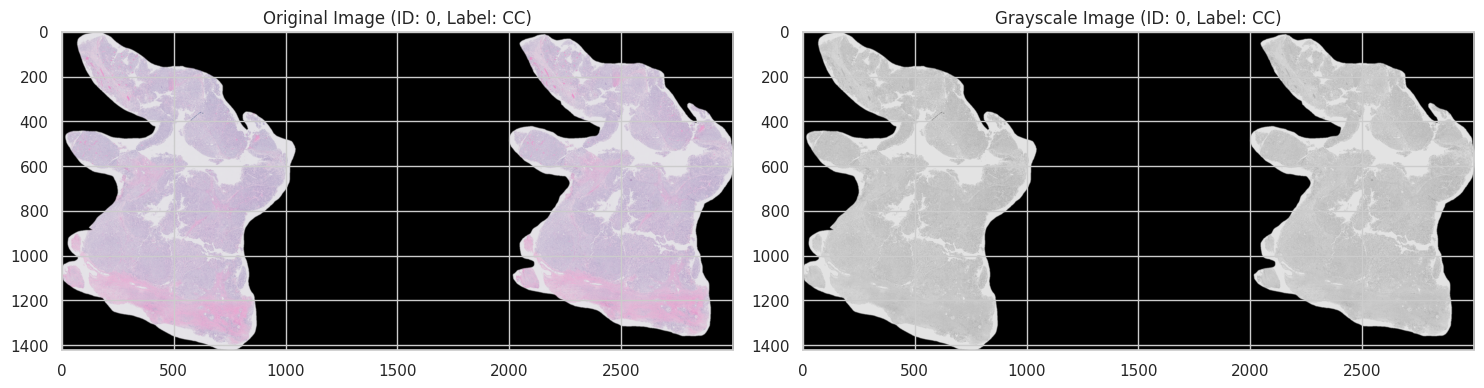

Flattened Array for Image ID 1 and Label EC:
[244 243 245 ... 245 241 244]



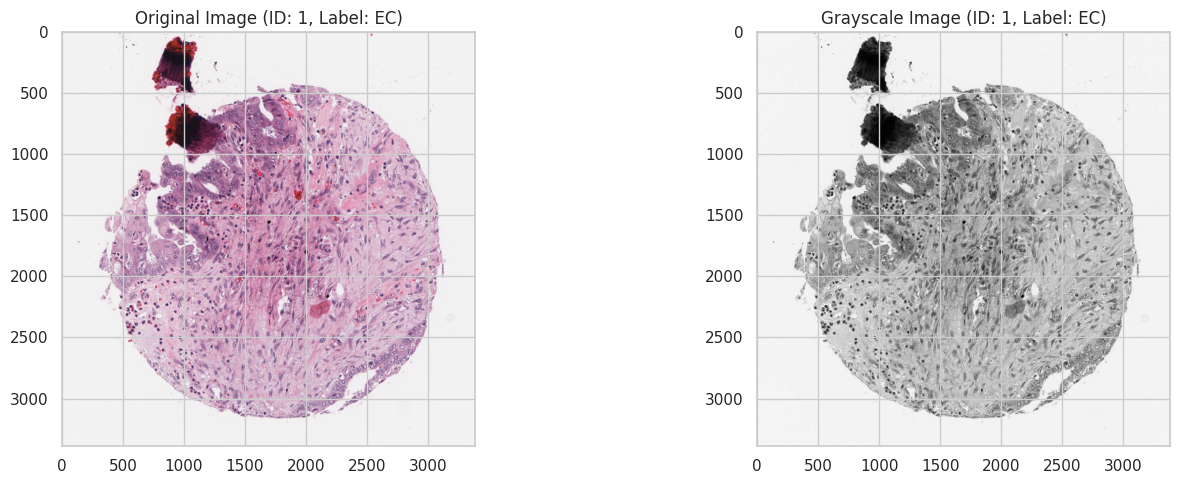

Flattened Array for Image ID 2 and Label HGSC:
[0 0 0 ... 0 0 0]



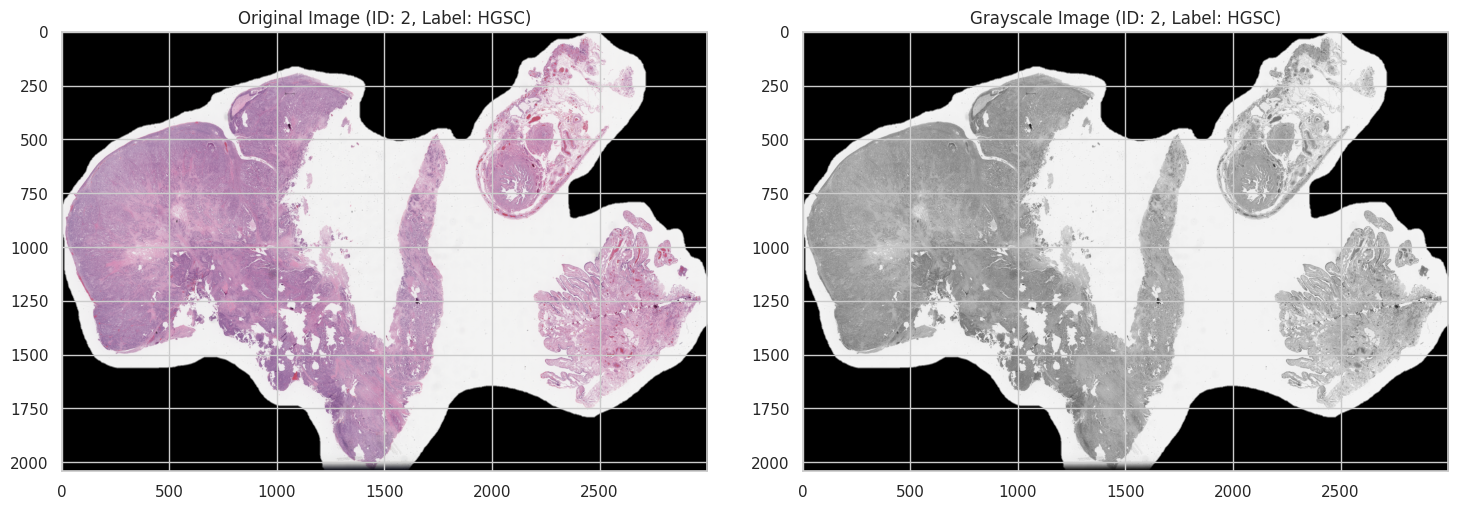

Flattened Array for Image ID 3 and Label LGSC:
[0 0 0 ... 0 0 0]



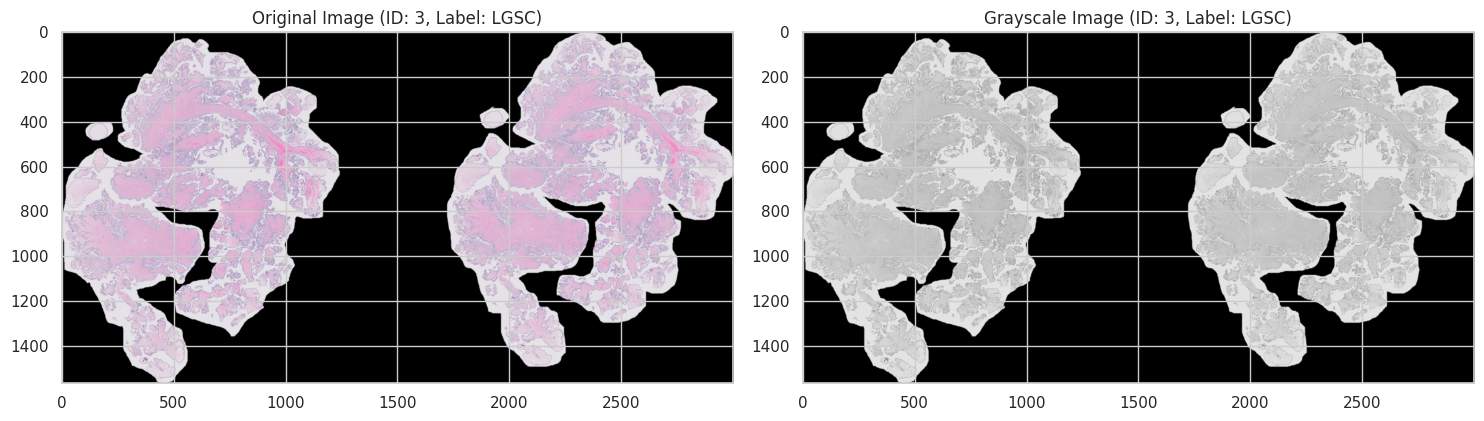

Flattened Array for Image ID 4 and Label MC:
[241 242 241 ... 238 243 239]



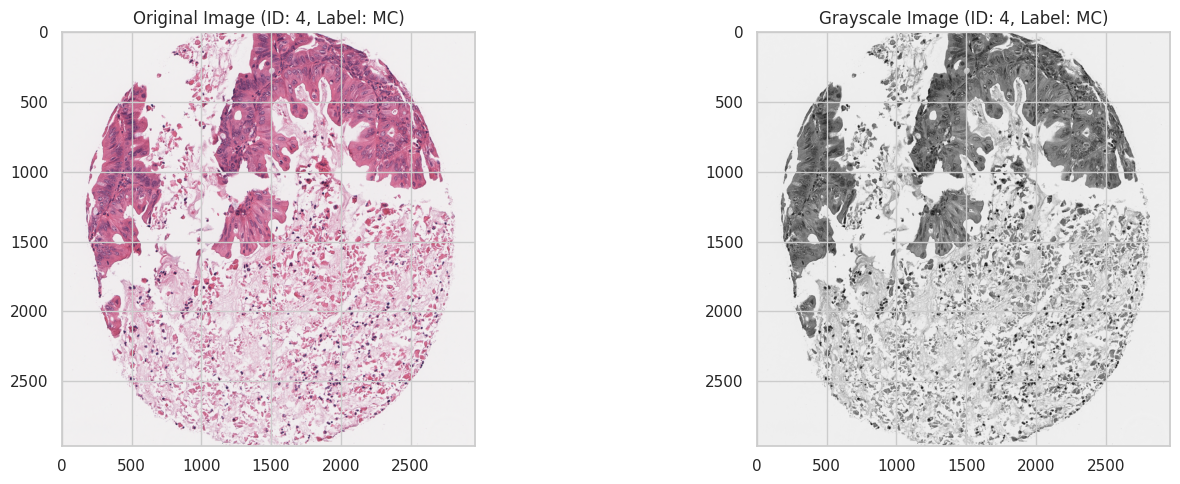

In [27]:
def apply_grayscale_and_plot(image_id, label, image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')

    flattened_array = np.array(grayscale_image).flatten()
    print(f"Flattened Array for Image ID {image_id} and Label {label}:\n{flattened_array}\n")

    plt.figure(figsize=(15, 5))

    # Create a subplot for the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image (ID: {image_id}, Label: {label})')

    # Create a subplot for the grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title(f'Grayscale Image (ID: {image_id}, Label: {label})')

    plt.tight_layout()
    plt.show()

    return flattened_array

flattened_arrays = []

for idx, row in feature_extraction_df.iterrows():
    grayscale_features = apply_grayscale_and_plot(idx, row['label'], row['full_path'])
    flattened_arrays.append(grayscale_features)

#### Conturing

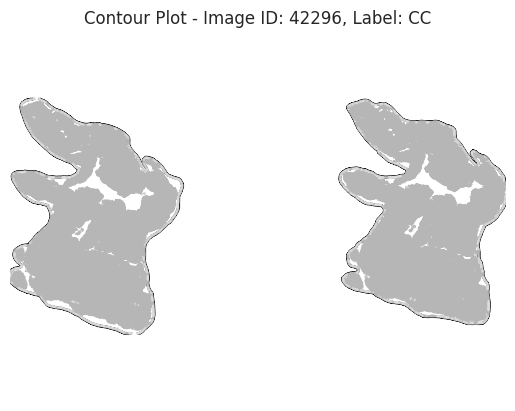

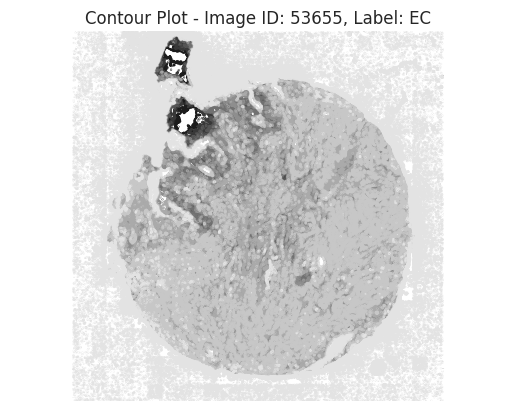

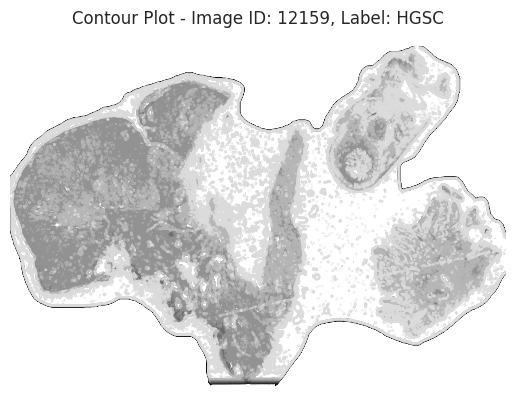

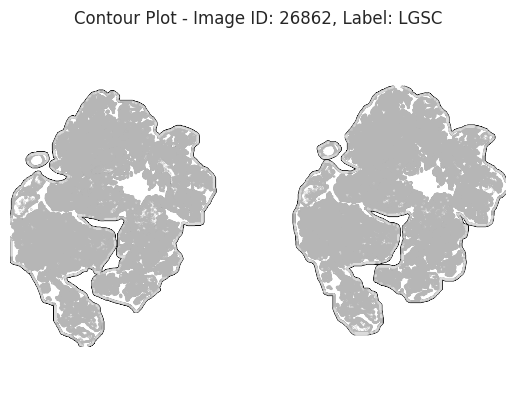

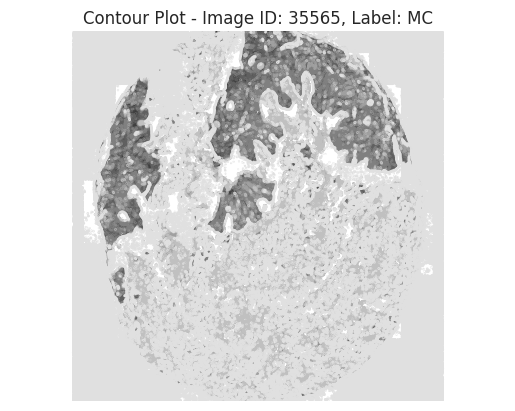

In [28]:
# Function to apply contour and histogram plots to an image
def apply_contour_and_histogram(image_path, image_id, label):
    # Open an image
    image = Image.open(image_path)

    # Convert the image to grayscale
    im_array = np.array(image.convert('L'))

    # Create a new figure for contour plot
    plt.figure()
    plt.gray()
    plt.contour(im_array, origin='image')
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'Contour Plot - Image ID: {image_id}, Label: {label}')


# Iterate over rows in feature_extraction_df
for idx, row in feature_extraction_df.iterrows():
    apply_contour_and_histogram(row['full_path'], row['image_id'], row['label'])

# Model - RestNet50

In [29]:
import keras.applications
print(dir( keras.applications))

['ConvNeXtBase', 'ConvNeXtLarge', 'ConvNeXtSmall', 'ConvNeXtTiny', 'ConvNeXtXLarge', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'RegNetX002', 'RegNetX004', 'RegNetX006', 'RegNetX008', 'RegNetX016', 'RegNetX032', 'RegNetX040', 'RegNetX064', 'RegNetX080', 'RegNetX120', 'RegNetX160', 'RegNetX320', 'RegNetY002', 'RegNetY004', 'RegNetY006', 'RegNetY008', 'RegNetY016', 'RegNetY032', 'RegNetY040', 'RegNetY064', 'RegNetY080', 'RegNetY120', 'RegNetY160', 'RegNetY320', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'ResNetRS101', 'ResNetRS152', 'ResNe

In [30]:
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, BatchNormalization, Activation, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l1, l2, l1_l2

In [31]:
def identity_block(input_tensor, kernel_size, filters, stage, block, use_bias=True, train_bn=True):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), use_bias=use_bias, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x, training=train_bn)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=use_bias, name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x, training=train_bn)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), use_bias=use_bias, name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x, training=train_bn)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), use_bias=True, train_bn=True):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, use_bias=use_bias, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x, training=train_bn)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=use_bias, name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x, training=train_bn)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), use_bias=use_bias, name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=use_bias, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(512, 512, 3), classes=5):
    img_input = Input(shape=input_shape)
    x = ZeroPadding2D((3, 3))(img_input)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), use_bias=True, name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x, training=True)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), use_bias=True, train_bn=True)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', use_bias=True, train_bn=True)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', use_bias=True, train_bn=True)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', use_bias=True, train_bn=True)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', use_bias=True, train_bn=True)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', use_bias=True, train_bn=True)
    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)


    model = Model(img_input, x, name='resnet50')
    return model

In [32]:
model = ResNet50()

# Evaluation

In [33]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define other callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=100)

In [34]:
from keras.optimizers import Adam


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 100
batch_size = 8

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                          steps_per_epoch=len(x_train) / batch_size,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          callbacks=[reduce_lr, early_stop])

Epoch 1/100
111/111 [==============================] - 111s 537ms/step - loss: 2.7848 - accuracy: 0.2444 - val_loss: 1.9156 - val_accuracy: 0.2207 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 51s 452ms/step - loss: 1.8161 - accuracy: 0.2613 - val_loss: 1.5396 - val_accuracy: 0.3288 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 50s 450ms/step - loss: 2.1127 - accuracy: 0.2669 - val_loss: 1.7624 - val_accuracy: 0.2162 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 51s 455ms/step - loss: 1.7322 - accuracy: 0.2691 - val_loss: 1.6273 - val_accuracy: 0.2793 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 50s 450ms/step - loss: 1.5644 - accuracy: 0.2838 - val_loss: 1.5135 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 6/100
111/111 [==============================] - 51s 457ms/step - loss: 1.4624 - accuracy: 0.3615 - val_loss: 1.4810 - val_accuracy: 0.3288 - lr: 1.0000e-04
Epoch 7/100
111/111 [================

In [35]:
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Accuracy: 0.6385135054588318
Validation Accuracy: 0.6711711883544922


# Classification report

In [36]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(x_val), axis=1)

# Generate the classification report
class_report = classification_report(y_true, y_pred)


print("\n Validation Classification Report:\n", class_report)

7/7 [==============================] - 4s 530ms/step

 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.82      0.71        44
           1       0.64      0.36      0.46        45
           2       0.65      0.34      0.45        44
           3       0.61      0.89      0.72        44
           4       0.81      0.96      0.88        45

    accuracy                           0.67       222
   macro avg       0.67      0.67      0.64       222
weighted avg       0.67      0.67      0.64       222



# Testing Model

In [37]:
test_data = pd.read_csv('../input/UBC-OCEAN/test.csv')
test_data

image_id  image_width  image_height
0        41        28469         16987

In [38]:
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'
test_data['full_path'] = test_data['image_id'].apply(lambda x: os.path.join(test_thumbnails_folder_path, f"{x}_thumbnail.png"))

In [39]:
x_test = np.empty(shape=(len(test_data), 512, 512, 3), dtype=np.uint8)

for index, full_path in enumerate(test_data['full_path']):
    image_array = Image.open(full_path).resize((512, 512)).convert('RGB')
    x_test[index] = image_array

print(x_test.shape)

(1, 512, 512, 3)


In [40]:
predictions = model.predict(x_test)
predictions

1/1 [==============================] - 1s 777ms/step


array([[0.01753753, 0.48909938, 0.1414919 , 0.16286063, 0.18901049]],
      dtype=float32)

In [41]:
test_data['label'] = predictions.argmax(axis=1)  # Assuming one-hot encoding, get the index of the max value
submission_df = test_data[['image_id', 'label']]

In [42]:
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Map numerical labels to actual labels
submission_df.loc[:, 'label'] = submission_df['label'].map(reverse_label_mapping)

submission_df

image_id label
0        41    EC

In [43]:
# Save to CSV
submission_df.to_csv('submission.csv', index=False)